In [1]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy import stats
import numpy as np
import xarray as xr
from astropy.time import Time
import metpy.calc as mp
from metpy.units import units
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

'''
Set up the functions
'''
def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

def setTrack(df,mooring):
    a = df[['TS_mean','linearSpeed','linearHead','Target_depth_mean','Num_targets','Target_range_mean','SigBS_mean']]
    cts,binL = np.histogram(a.linearHead,bins=36,range=[0,360])
    binL = binL[:-1]
    a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
    a['mooring'] = mooring
    return a

def fmtAxis(ax):
    maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
    ax.xaxis.set_major_locator(maj_loc)
    min_loc = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(min_loc)
    zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
    ax.xaxis.set_major_formatter(maj_fmt)

def rotUV(u,v,rot):
    v1 = (-u*np.sin(rot*np.pi/180))+(v*np.cos(rot*np.pi/180))
    u1 = (u*np.cos(rot*np.pi/180))+(v*np.sin(rot*np.pi/180))
    return u1,v1

def uv(wspd, wdir):
    rad = 4.0*np.arctan(1)/180.
    wdir = wdir-180
    u = -wspd*np.sin(rad*wdir)
    v = -wspd*np.cos(rad*wdir)
    return round(u,3),round(v,3)

def rotateVectors(dfCur):
    dfCur['rotateDeg']=np.nan
    dfCur.loc[dfCur.mooring==1,'rotateDeg'] = 45 
    dfCur.loc[dfCur.mooring==2,'rotateDeg'] = 75 
    dfCur.loc[dfCur.mooring==3,'rotateDeg'] = 65
    tu,tv = uv(dfCur.linearSpeed*100,dfCur.linearHead)
    dfCur['trackU'] = tu
    dfCur['trackV'] = tv

    tur,tvr = rotUV(dfCur.trackU,dfCur.trackV,-dfCur.rotateDeg)
    dfCur['trackUrotated'] = tur
    dfCur['trackVrotated'] = tvr

    aur,avr = rotUV(dfCur.current_u,dfCur.current_v,-dfCur.rotateDeg)
    dfCur['adcpUrotated'] = aur
    dfCur['adcpVrotated'] = avr
    return dfCur

'''
Read in the track data from the 'buildTrackData_linear' notebook
'''
# Set to 3 for the new version with .6 and pmodified ping count
df1 = readTracks('../data/analysisFiles/TrackRegions1_linear4.csv')
df1['SigBS_mean'] = 10**(df1.TS_mean/10)
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear4.csv')
df2['SigBS_mean'] = 10**(df2.TS_mean/10)
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear4.csv')
df4['SigBS_mean'] = 10**(df4.TS_mean/10)
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear4.csv')
df5['SigBS_mean'] = 10**(df5.TS_mean/10)
df6 = readTracks('../data/analysisFiles/TrackRegions6_linear4.csv')
df6['SigBS_mean'] = 10**(df6.TS_mean/10)
dt1 = setTrack(df1,1)
dt2 = setTrack(df2,2)
dt4 = setTrack(df4,1)
dt5 = setTrack(df5,2)
dt6 = setTrack(df6,3)

'''
Now we
1) Read in the corresponding adcp data for each deployment of tracks
2) For each track, find the nearest time and depth measurement of u and v
3) Calculate the current speed and direction from the u and v (for reference)
4) Assemble new dataframe with the adcp data merged
5) Add with/against headig key
6) for both track and adcp, take calculate the u and v of the ROTATED heading. These headings are hardcoded above and come from the flux workbook.
'''
files = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc',
    '../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc',
    '../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc']
trackSets = [dt1,dt4,dt2,dt5,dt6]
newTrackSets = []
for i in [0,1,2,3,4]:
    ds = xr.open_dataset(files[i],decode_times=False)
    times = ds.time.values+ds.time2.values/1000/60/60/24
    t2 = [Time(time,format='jd').iso for time in times]
    ds.coords['time'] = pd.to_datetime(t2)
    dt = trackSets[i]
    dt[['current_u','current_v','current_depth']] = np.nan
    for index,row in tqdm(dt.iterrows(),total=len(dt)):
        curDs = ds.sel(time = index,depth = row.Target_depth_mean, method='nearest')
        dt.loc[(dt.index==index)&(dt.TS_mean==row.TS_mean), 'current_u'] = curDs.u_1205.values[0][0]
        dt.loc[(dt.index==index)&(dt.TS_mean==row.TS_mean), 'current_v'] = curDs.v_1206.values[0][0]
        dt.loc[(dt.index==index)&(dt.TS_mean==row.TS_mean), 'current_depth'] = curDs.depth.values
    dt['currentDir'] = mp.wind_direction(dt.current_u.values*units('cm/s'), dt.current_v.values*units('cm/s'),convention='to')
    dt['currentSpeed'] = mp.wind_speed(dt.current_u.values*units('cm/s'), dt.current_v.values*units('cm/s'))
    newTrackSets.append(dt)
dfMerge = pd.concat(newTrackSets)
dfMerge['withPrimary'] = 0 # set all, this will also be for 'milling'
dfMerge.loc[abs(dfMerge.rotateHead) <90, 'withPrimary'] = 1 # with current
dfMerge.loc[abs(dfMerge.rotateHead >90), 'withPrimary'] = 2 # against current
dfMerge= dfMerge[(dfMerge.currentSpeed <1000)] # clean out noise
dfMerge = rotateVectors(dfMerge)
dfMerge['sigmaBs'] = 10**(dfMerge.TS_mean/10)
dfMerge.to_pickle('../data/analysisFiles/dfMerge.pkl')

In [2]:
from glob import glob
# Moorings
from evFileProcessing import evFuncs
dfd1 = evFuncs.evExports.readEvExports(glob('../data/2018/EVFiles/DAFT1/exports/1m/70kHz*.csv'))
dfd2 = evFuncs.evExports.readEvExports(glob('../data/2018/EVFiles/DAFT2/exports/1m/70kHz*.csv'))
dfd4 = evFuncs.evExports.readEvExports(glob('../data/2019/EVFiles/DAFT1/exports/1m/70kHz*.csv'))
dfd5 = evFuncs.evExports.readEvExports(glob('../data/2019/EVFiles/DAFT2/exports/1m/70kHz*.csv'))
dfd6 = evFuncs.evExports.readEvExports(glob('../data/2019/EVFiles/DAFT3/exports/1m/70kHz*.csv'))

df1sA = pd.concat([dfd1,dfd4])
df2sA = pd.concat([dfd2,dfd5])
df3sA = dfd6

In [35]:
def fluxDF(dfTracks, dfsa):
    curTracks = dfTracks.resample('2H').mean()
    curSa = dfsa.resample('2H').sum()[['sA']]
    curDf = curTracks.merge(curSa,left_index=True, right_index=True)
    curDf['sa'] = curDf.sA/(4*np.pi*(1852**2))
    curDf['abund'] = curDf.sa/curDf.sigmaBs
    curDf['fluxVrotated'] = curDf.abund*(curDf.trackVrotated/100)
    curDf['adcpfluxVrotated'] = curDf.abund*(curDf.adcpVrotated/100)
    return curDf

dfFlux1 = fluxDF(dfMerge[dfMerge.mooring==1],df1sA)
dfFlux2 = fluxDF(dfMerge[dfMerge.mooring==2],df2sA)
dfFlux3 = fluxDF(dfMerge[dfMerge.mooring==3],df3sA)

2019-07-31    0.906243
Freq: 7D, Name: fluxVrotated, dtype: float64

ice 1.9713377721088121 no ice 13.869309423498878
Ttest_indResult(statistic=-2.6136944449935267, pvalue=0.01163320423498995)


Datetime
2017-09-13    2.624933
Freq: 7D, Name: fluxVrotated, dtype: float64

ice 5.987495062113774 no ice 10.743917010426937
Ttest_indResult(statistic=-1.7504943772406836, pvalue=0.0828993007706468)


2017-09-12    1.116199
Freq: 7D, Name: fluxVrotated, dtype: float64

ice 7.889022376285353 no ice 8.248716810714097
Ttest_indResult(statistic=-0.18578336847199153, pvalue=0.8529730767731277)


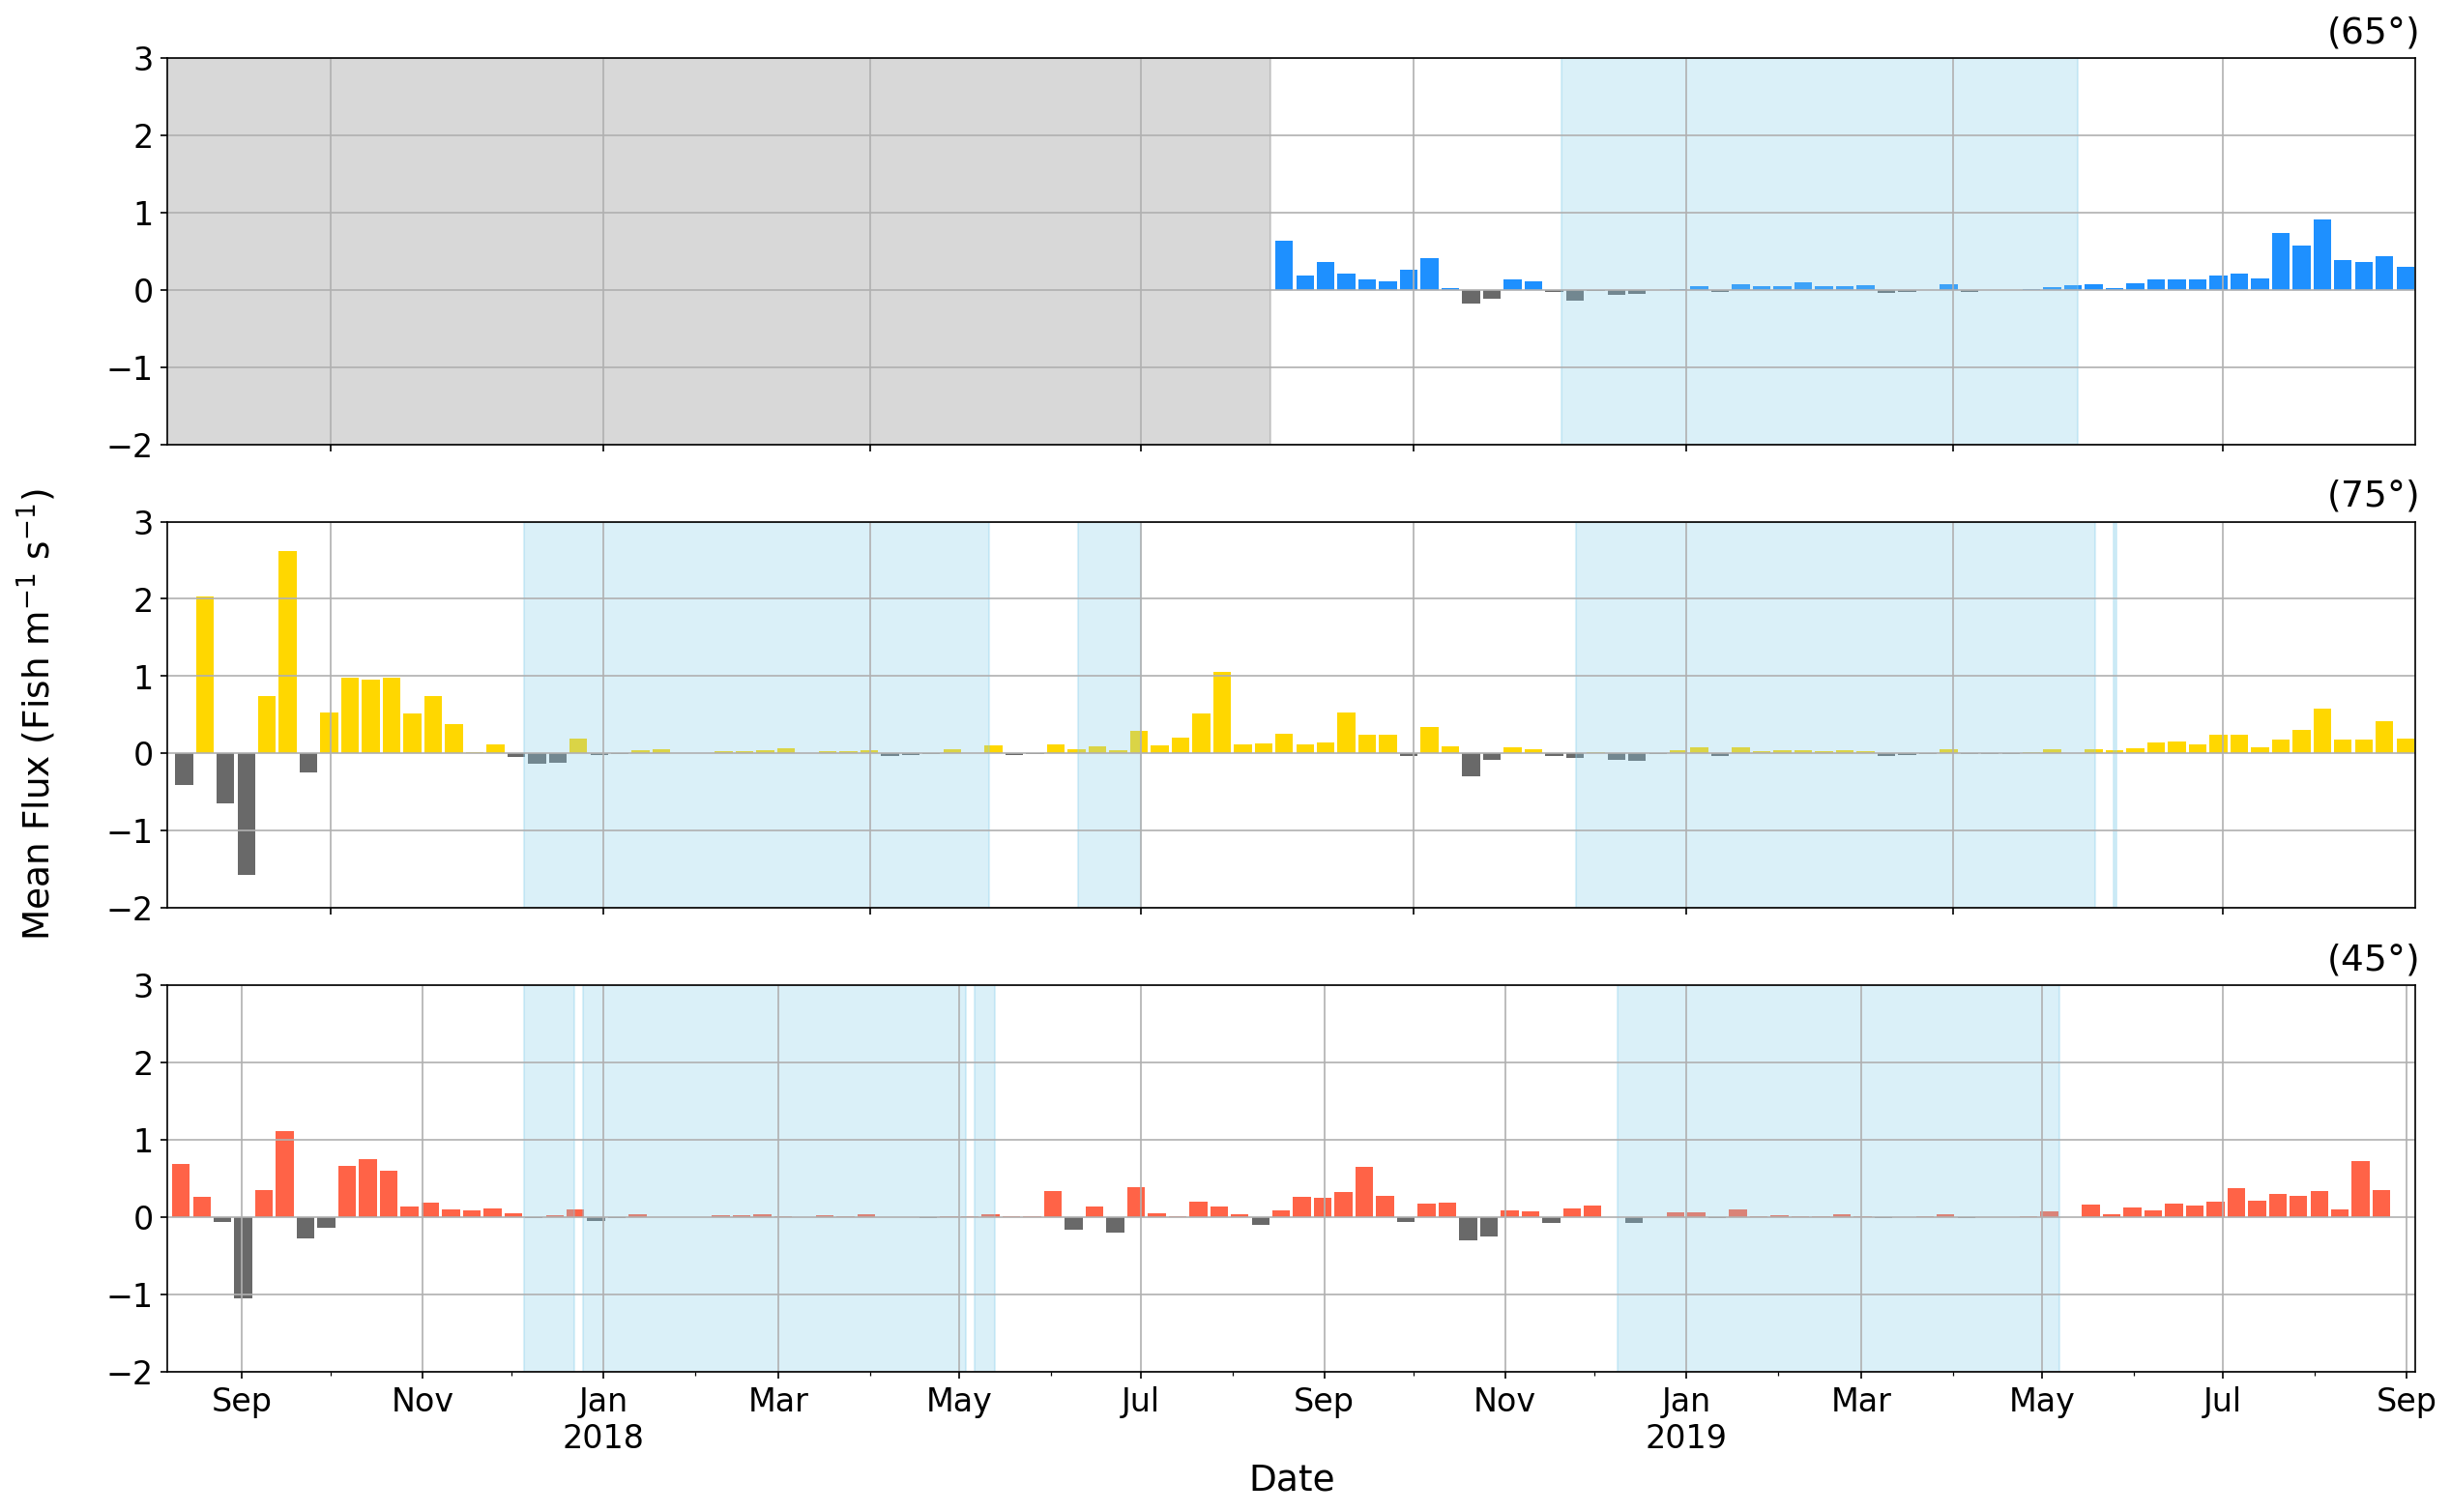

In [5]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

def iceDates(df):
    df['o20']= 0
    df['o20'][(df.iceC > .2)] = 1
    df['shift'] = df['o20'].diff()
    dfShift = df[(df['shift'] != 0)&(~df['shift'].isnull())]
    dates = dfShift.index.values
    iceD = np.array(dates).reshape(int(len(dates)/2),2)
    return iceD

# Ice
dfD1Ice = pd.read_csv('../data/physicalData/C11_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD2Ice = pd.read_csv('../data/physicalData/C1_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD3Ice = pd.read_csv('../data/physicalData/C4_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')

plt.rcParams.update({'font.size':16})
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,12),sharex=True, sharey=True,dpi = 150)

ax1=plt.subplot(311)
a = dfFlux3.resample('7D').mean()
ax1.bar(a.index.where(a.fluxVrotated.ge(0), np.nan)+pd.Timedelta(days=3.5),a.fluxVrotated.where(a.fluxVrotated.ge(0), np.nan),color='dodgerblue',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax1.bar(a.index.where(a.fluxVrotated.lt(0), np.nan)+pd.Timedelta(days=3.5),a.fluxVrotated.where(a.fluxVrotated.lt(0), np.nan),color='dimgrey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.text(pd.to_datetime('2019-08-05'),3.2,str('('+str(int(np.max(a.rotateDeg.unique()[0])))+'$\degree$)'),fontsize=18)
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
ax1.set_ylim([-2,3])
#plt.title('Flux from Echosounder',fontsize=18)
display(a[a.fluxVrotated == a.fluxVrotated.max()].fluxVrotated)
iceCov = iceDates(dfD3Ice)
for b in iceCov:
    ax1.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue')
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
print('ice',a[a.ice==1].adcpVrotated.mean(),'no ice',a[a.ice==0].adcpVrotated.mean())
print(ttest_ind(a[a.ice==1].adcpVrotated,a[a.ice==0].adcpVrotated))
    
    
ax2=plt.subplot(312)
a = dfFlux2.resample('7D').mean()
ax2.bar(a.index.where(a.fluxVrotated.ge(0), np.nan)+pd.Timedelta(days=3.5),a.fluxVrotated.where(a.fluxVrotated.ge(0), np.nan),color='gold',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.bar(a.index.where(a.fluxVrotated.lt(0), np.nan)+pd.Timedelta(days=3.5),a.fluxVrotated.where(a.fluxVrotated.lt(0), np.nan),color='dimgrey',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.grid()
ax2.text(pd.to_datetime('2019-08-05'),3.2,str('('+str(int(np.max(a.rotateDeg.unique()[0])))+'$\degree$)'),fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
ax2.set_ylim([-2,3])
plt.ylabel('Mean Flux (Fish m$^{-1}$ s$^{-1}$)\n',fontsize=18)
display(a[a.fluxVrotated == a.fluxVrotated.max()].fluxVrotated)
iceCov = iceDates(dfD2Ice)
for b in iceCov:
    ax2.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue')
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
print('ice',a[a.ice==1].adcpVrotated.mean(),'no ice',a[a.ice==0].adcpVrotated.mean())
print(ttest_ind(a[a.ice==1].adcpVrotated,a[a.ice==0].adcpVrotated))
    
ax3=plt.subplot(313)
a = dfFlux1.resample('7D').mean()
ax3.bar(a.index.where(a.fluxVrotated.ge(0), np.nan)+pd.Timedelta(days=3.5),a.fluxVrotated.where(a.fluxVrotated.ge(0), np.nan),color='tomato',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax3.bar(a.index.where(a.fluxVrotated.lt(0), np.nan)+pd.Timedelta(days=3.5),a.fluxVrotated.where(a.fluxVrotated.lt(0), np.nan),color='dimgrey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax3.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax3.grid()
ax3.text(pd.to_datetime('2019-08-05'),3.2,str('('+str(int(np.max(a.rotateDeg.unique()[0])))+'$\degree$)'),fontsize=18)
ax3.set_ylim([-2,3])
plt.xlabel('Date',fontsize=18)
display(a[a.fluxVrotated == a.fluxVrotated.max()].fluxVrotated)
iceCov = iceDates(dfD1Ice)
for b in iceCov:
    ax3.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue')

a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
print('ice',a[a.ice==1].adcpVrotated.mean(),'no ice',a[a.ice==0].adcpVrotated.mean())
print(ttest_ind(a[a.ice==1].adcpVrotated,a[a.ice==0].adcpVrotated))

fmtAxis(ax3)


18.08307715822009
4494.532045180978
260.89467101458933


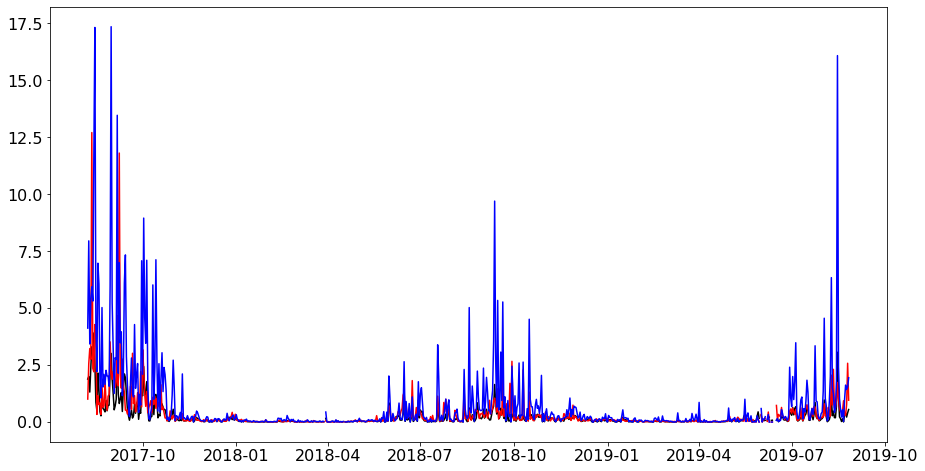

In [63]:
fig = plt.figure(figsize=(15,8))
curDF = dfFlux1.resample('1D').mean()
plt.plot(abs(curDF.trackVrotated/100*curDF.abund),'k')
curDFmin = dfFlux1.resample('1D').min()
curDFmax = dfFlux1.resample('1D').max()
plt.plot(abs((curDFmax.trackVrotated-curDFmin.trackVrotated)/100*curDF.abund),'r')
plt.plot(abs(curDF.trackVrotated/100*(curDFmax.abund-curDFmin.abund)),'b')
#plt.plot(abs((curDFmax.trackVrotated-curDFmin.trackVrotated)/100*(curDFmax.abund-curDFmin.abund)),'b')
print(dfFlux1.abund.mean()*dfFlux1.trackVrotated.mean())
print((dfFlux1.abund.max()-dfFlux1.abund.min())*dfFlux1.trackVrotated.mean())
print(dfFlux1.abund.mean()*(dfFlux1.trackVrotated.max()-dfFlux1.trackVrotated.min()))

0.734449


(<matplotlib.patches.Rectangle at 0x22585ec5a30>,
 (<matplotlib.patches.ConnectionPatch at 0x22585ecbbb0>,
  <matplotlib.patches.ConnectionPatch at 0x22585ed53d0>))

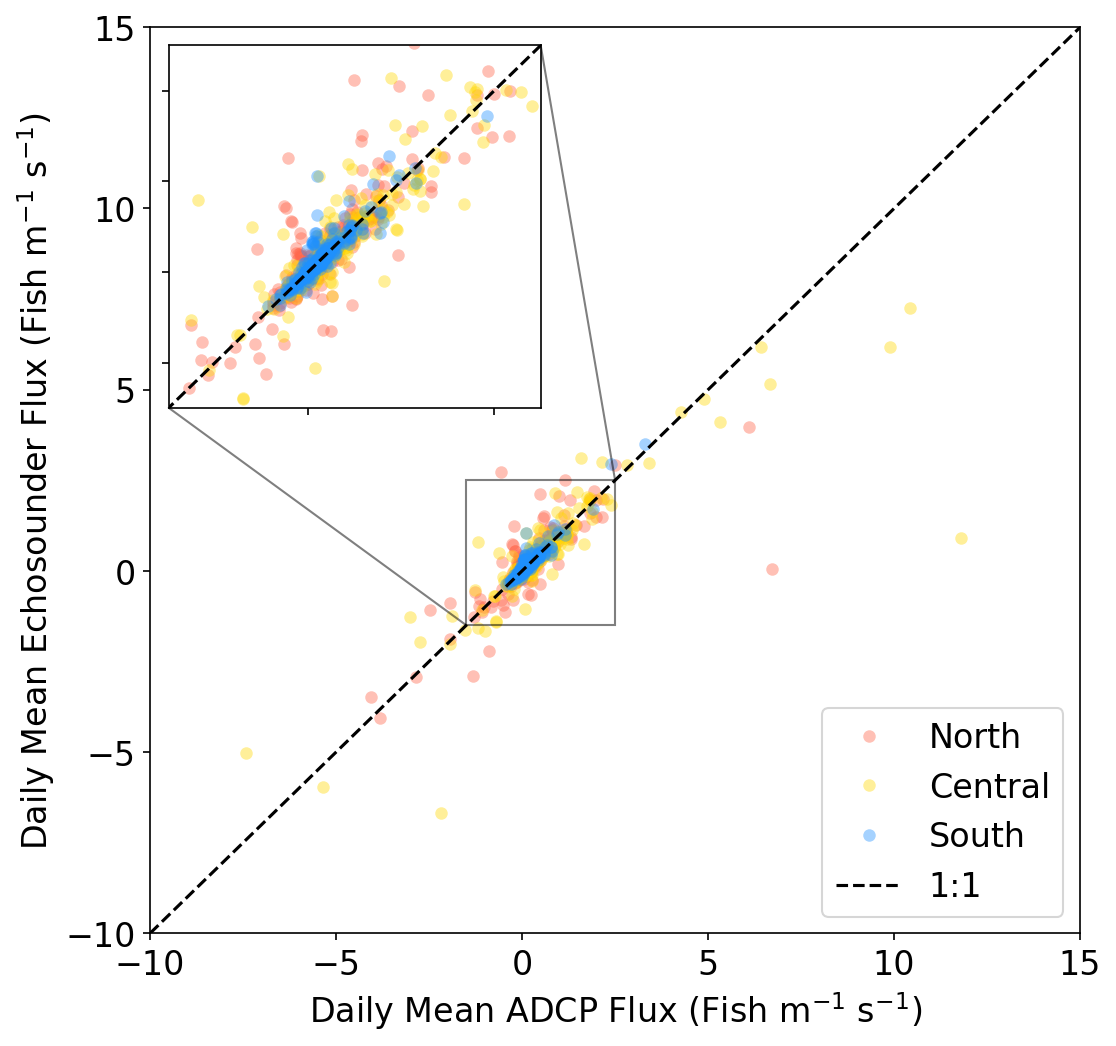

In [60]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (8,8),dpi=150)
ax = plt.subplot(111)
ax.plot(dfFlux1.resample('1D').mean().adcpfluxVrotated, dfFlux1.resample('1D').mean().fluxVrotated,'.',color='tomato',markersize=12, alpha=0.4,markeredgecolor='None')
ax.plot(dfFlux2.resample('1D').mean().adcpfluxVrotated, dfFlux2.resample('1D').mean().fluxVrotated,'.',color='gold',markersize=12, alpha=0.4,markeredgecolor='None')
ax.plot(dfFlux3.resample('1D').mean().adcpfluxVrotated, dfFlux3.resample('1D').mean().fluxVrotated,'.',color='dodgerblue',markersize=12, alpha=0.4,markeredgecolor='None')
ax.axis([-10,15,-10,15])
ax.plot([-10,15],[-10,15],'--k')
ax.set_xlabel('Daily Mean ADCP Flux (Fish m$^{-1}$ s$^{-1}$)')
ax.set_ylabel('Daily Mean Echosounder Flux (Fish m$^{-1}$ s$^{-1}$)')
plt.legend(['North','Central','South','1:1'])
a = np.concatenate([dfFlux1.resample('1D').mean().adcpfluxVrotated,dfFlux2.resample('1D').mean().adcpfluxVrotated,dfFlux3.resample('1D').mean().adcpfluxVrotated])
b = np.concatenate([dfFlux1.resample('1D').mean().fluxVrotated,dfFlux2.resample('1D').mean().fluxVrotated,dfFlux3.resample('1D').mean().fluxVrotated])
pr = np.round(np.corrcoef(a[~np.isnan(a)],b[~np.isnan(a)])[0][1],3)
print(pr**2)
#plt.title('R$^{2}$ = '+str(np.round(pr**2,2)))


axins = ax.inset_axes([0.02, 0.58, 0.4, 0.4])
axins.plot(dfFlux1.resample('1D').mean().adcpfluxVrotated, dfFlux1.resample('1D').mean().fluxVrotated,'.',color='tomato',markersize=12, alpha=0.4,markeredgecolor='None')
axins.plot(dfFlux2.resample('1D').mean().adcpfluxVrotated, dfFlux2.resample('1D').mean().fluxVrotated,'.',color='gold',markersize=12, alpha=0.4,markeredgecolor='None')
axins.plot(dfFlux3.resample('1D').mean().adcpfluxVrotated, dfFlux3.resample('1D').mean().fluxVrotated,'.',color='dodgerblue',markersize=12, alpha=0.4,markeredgecolor='None')
axins.plot([-15,15],[-15,15],'--k')
## sub region of the original image
x1, x2, y1, y2 = -1.5,2.5,-1.5,2.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins, edgecolor="black")

(0.0, 30.0, 0.0, 2.7)

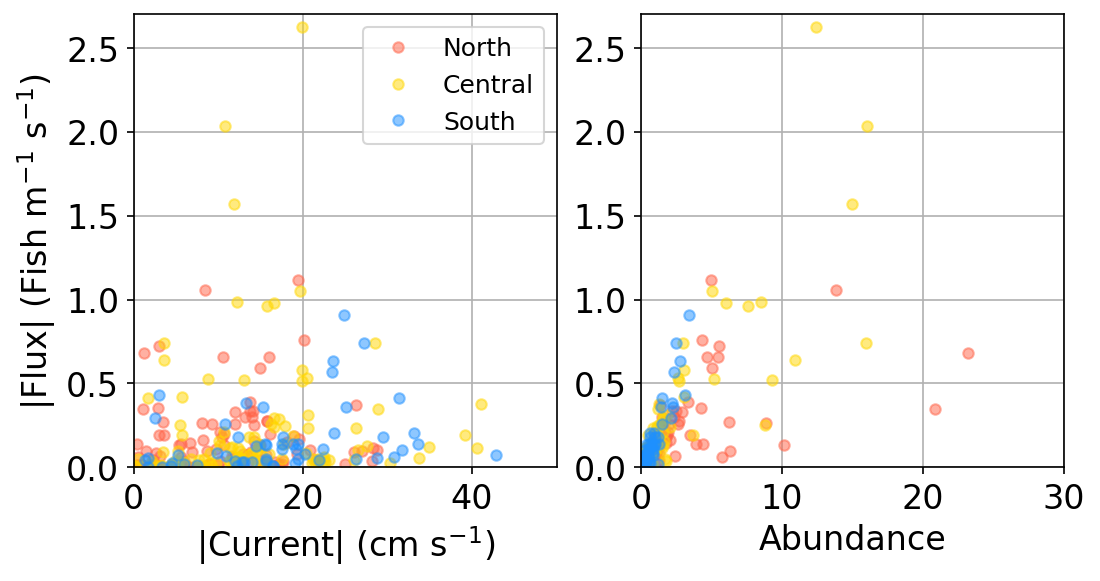

In [6]:
fig = plt.figure(figsize=(8,4),dpi=150)
plt.subplot(121)
plt.plot(abs(dfFlux1.resample('7D').mean().adcpVrotated),abs(dfFlux1.resample('7D').mean().fluxVrotated),'.',color='tomato',markersize=10,alpha=0.5)
plt.plot(abs(dfFlux2.resample('7D').mean().adcpVrotated),abs(dfFlux2.resample('7D').mean().fluxVrotated),'.',color='gold',markersize=10,alpha=0.5)
plt.plot(abs(dfFlux3.resample('7D').mean().adcpVrotated),abs(dfFlux3.resample('7D').mean().fluxVrotated),'.',color='dodgerblue',markersize=10,alpha=0.5)
plt.ylabel ('|Flux| (Fish m$^{-1}$ s$^{-1}$)')
plt.xlabel('|Current| (cm s$^{-1}$)')
plt.grid()
plt.axis([0,50,0,2.7])
plt.legend(['North','Central','South'],fontsize=12)

plt.subplot(122)
plt.plot(dfFlux1.resample('7D').mean().abund,abs(dfFlux1.resample('7D').mean().fluxVrotated),'.',color='tomato',markersize=10,alpha=0.5)
plt.plot(dfFlux2.resample('7D').mean().abund,abs(dfFlux2.resample('7D').mean().fluxVrotated),'.',color='gold',markersize=10,alpha=0.5)
plt.plot(dfFlux3.resample('7D').mean().abund,abs(dfFlux3.resample('7D').mean().fluxVrotated),'.',color='dodgerblue',markersize=10,alpha=0.5)
plt.xlabel('Abundance')
plt.grid()
plt.axis([0,30,0,2.7])

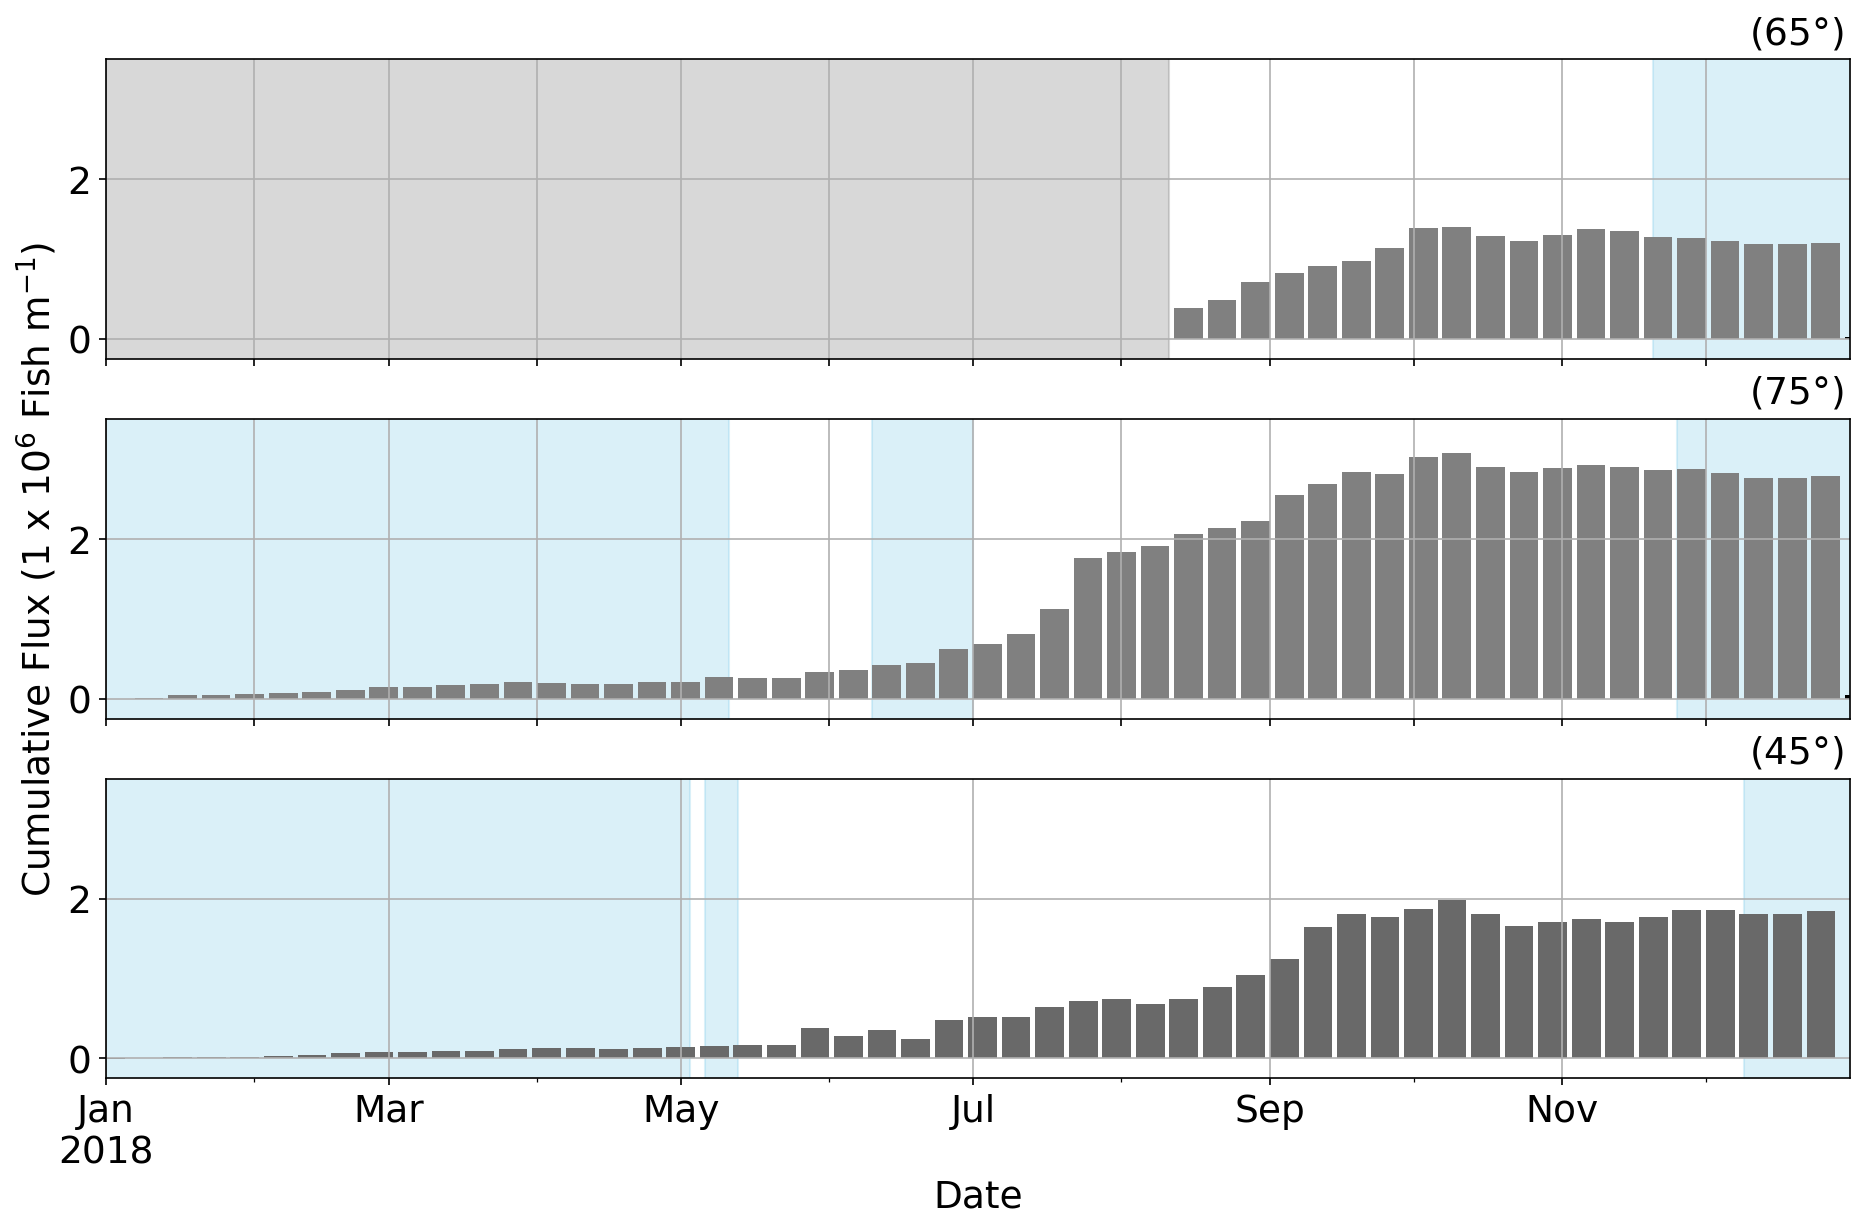

In [107]:
def iceDates(df):
    df['o20']= 0
    df['o20'][(df.iceC > .2)] = 1
    df['shift'] = df['o20'].diff()
    dfShift = df[(df['shift'] != 0)&(~df['shift'].isnull())]
    dates = dfShift.index.values
    iceD = np.array(dates).reshape(int(len(dates)/2),2)
    return iceD

# Ice
dfD1Ice = pd.read_csv('../data/physicalData/C11_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD2Ice = pd.read_csv('../data/physicalData/C1_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD3Ice = pd.read_csv('../data/physicalData/C4_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')

plt.rcParams.update({'font.size':18})
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(15,9),sharex=True, sharey=True,dpi = 150)

ax1=plt.subplot(311)
a = dfFlux3.resample('7D').mean()
ax1.bar(a.index,np.cumsum(a.fluxVrotated.where(a.index <pd.to_datetime('2018-01-01')))*60*60*24*7/1e6,color='silver',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax1.bar(a.index,np.cumsum(a.fluxVrotated.where((a.index >pd.to_datetime('2018-01-01'))&(a.index <pd.to_datetime('2019-01-01'))))*60*60*24*7/1e6,color='grey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax1.bar(a.index,np.cumsum(a.fluxVrotated.where(a.index >pd.to_datetime('2019-01-01')))*60*60*24*7/1e6,color='black',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-11'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2018-1-1'),pd.to_datetime('2018-12-31')])
ax1.grid()
#ax1.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax1.text(pd.to_datetime('2018-12-10'),3.7,str('('+str(int(a.rotateDeg.unique()[0])+'$\degree$)'),fontsize=18)
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
ax1.set_ylim([-.25,3.5])
#plt.title('Flux from Echosounder',fontsize=18)

iceCov = iceDates(dfD3Ice)
for b in iceCov:
    ax1.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder = 0)
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
#print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())
    
    
ax2=plt.subplot(312)
a = dfFlux2.resample('7D').mean()
ax2.bar(a.index,np.cumsum(a.fluxVrotated.where(a.index <pd.to_datetime('2018-01-01')))*60*60*24*7/1e6,color='silver',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.bar(a.index,np.cumsum(a.fluxVrotated.where((a.index >pd.to_datetime('2018-01-01'))&(a.index <pd.to_datetime('2019-01-01'))))*60*60*24*7/1e6,color='grey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax2.bar(a.index,np.cumsum(a.fluxVrotated.where(a.index >pd.to_datetime('2019-01-01')))*60*60*24*7/1e6,color='black',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.set_xlim([pd.to_datetime('2018-1-1'),pd.to_datetime('2018-12-31')])
ax2.grid()
ax2.text(pd.to_datetime('2018-12-10'),3.7,str('('+str(int(a.rotateDeg.unique()[0]))+'$\degree$)'),fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
ax2.set_ylim([-.25,3.5])
plt.ylabel('Cumulative Flux (1 x 10$^{6}$ Fish m$^{-1}$)',fontsize=18)

iceCov = iceDates(dfD2Ice)
for b in iceCov:
    ax2.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder = 0)
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
#print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())
    
ax3=plt.subplot(313)
a = dfFlux1.resample('7D').mean()
ax3.bar(a.index,np.cumsum(a.fluxVrotated.where(a.index <pd.to_datetime('2018-01-01')))*60*60*24*7/1e6,color='silver',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax3.bar(a.index,np.cumsum(a.fluxVrotated.where((a.index >pd.to_datetime('2018-01-01'))&(a.index <pd.to_datetime('2019-01-01'))))*60*60*24*7/1e6,color='dimgrey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax3.bar(a.index,np.cumsum(a.fluxVrotated.where(a.index >pd.to_datetime('2019-01-01')))*60*60*24*7/1e6,color='black',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax3.set_xlim([pd.to_datetime('2018-1-1'),pd.to_datetime('2018-12-31')])
ax3.grid()
#ax3.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.2,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax3.text(pd.to_datetime('2018-12-10'),3.7,str('('+str(int(a.rotateDeg.unique()[0]))+'$\degree$)'),fontsize=18)
ax3.set_ylim([-.25,3.5])
plt.xlabel('Date',fontsize=18)
iceCov = iceDates(dfD1Ice)
for b in iceCov:
    ax3.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder = 0)

a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
#print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())

fmtAxis(ax3)


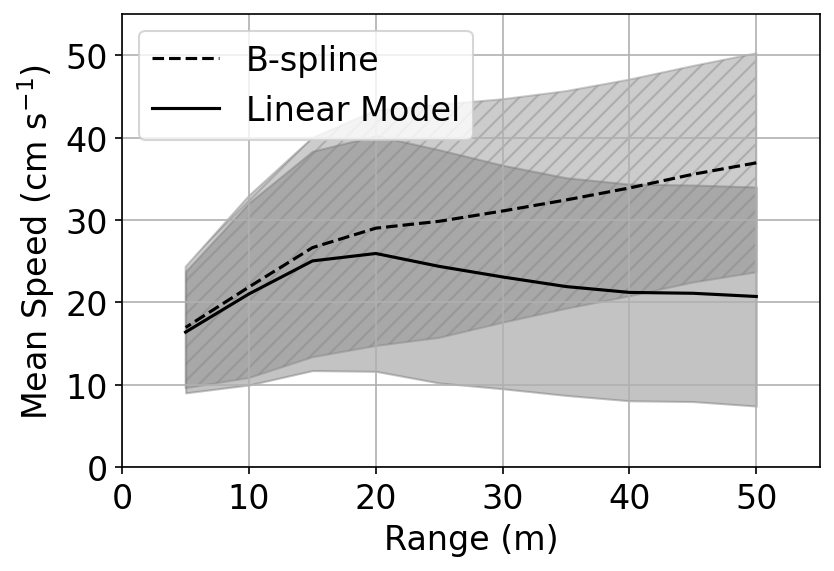

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import sem
allT = pd.concat([df1,df2,df4,df5,df6])
#allT = dfD1T
r = 5

spDir,spLin,spSmooth,spLinSD,spSmoothSD = [],[],[],[],[]
for d in np.arange(0,50,r):
    spDir.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].directSpeed.mean()*100)
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed.mean()*100)
    spLinSD.append(np.std(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100))
    spSmoothSD.append(np.std(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100))
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed.mean()*100)
    
error = .2
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0,50,r),spSmooth,'--k')
plt.plot(np.arange(0,50,r),spLin,'-k')
plt.fill_between(np.arange(0,50,r),np.array(spLin)-np.array(spLinSD),np.array(spLin)+np.array(spLinSD),color='dimgrey',alpha=0.4)
plt.fill_between(np.arange(0,50,r),np.array(spSmooth)-np.array(spSmoothSD),np.array(spSmooth)+np.array(spSmoothSD),color='grey',alpha=0.4,hatch='///')
plt.axis([-5,50,0,55])
plt.gca().invert_xaxis()
plt.xticks(np.arange(0,51,10))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,-1,-10)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
plt.legend(['B-spline','Linear Model'],loc='upper left')
plt.grid()

In [44]:
dfMerge[dfMerge.mooring==1].resample('2H').mean().iloc[0]

TS_mean             -50.612580
linearSpeed           0.172150
linearHead           80.626200
Target_depth_mean    23.672217
Num_targets          13.950000
Target_range_mean    23.559373
SigBS_mean            0.000063
rotateHead           40.626200
mooring               1.000000
current_u             3.699418
current_v             5.652206
current_depth        21.400000
currentDir           71.896641
currentSpeed          7.131756
withPrimary           1.100000
rotateDeg            45.000000
trackU                9.710300
trackV               10.501450
trackUrotated        -0.559428
trackVrotated        14.291865
adcpUrotated         -1.380830
adcpVrotated          6.612597
Name: 2017-08-08 04:00:00, dtype: float64

Text(35, -80, 'R$^{2}$=0.77')

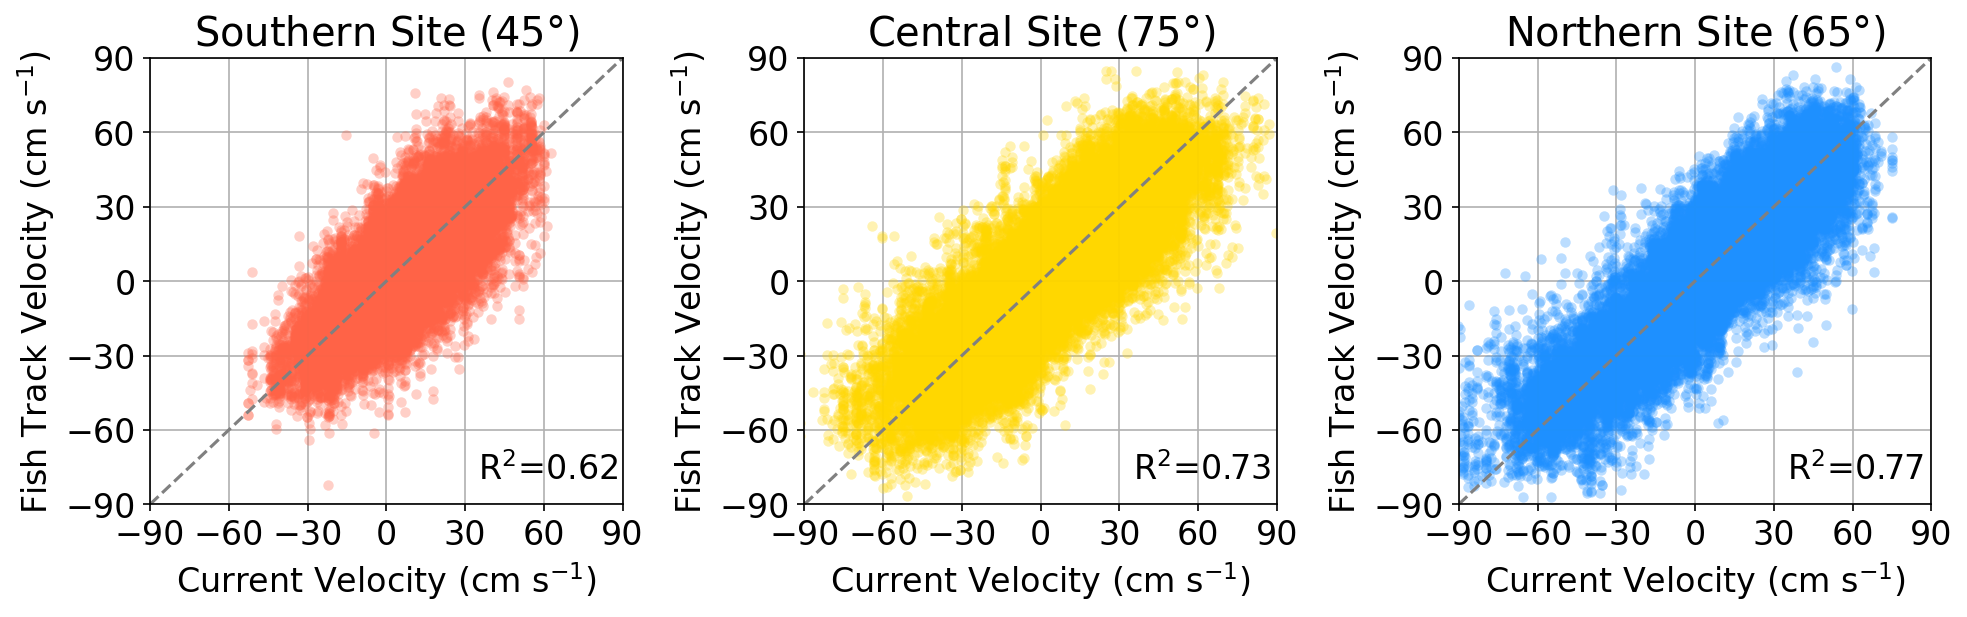

In [533]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)



df = dfMerge[dfMerge.mooring==1]
ax1.plot(df.adcpVrotated,df.trackVrotated,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax1.plot([-90,90],[-90,90],'--',color='grey')
ax1.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax1.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax1.set_xticks(np.arange(-90,91,30))
ax1.set_yticks(np.arange(-90,91,30))
ax1.axis([-90,90,-90,90])
ax1.set_title('Southern Site (45$\degree$)')
ax1.grid()
ax1.text(35,-80,'R$^{2}$='+str(np.round(np.corrcoef(df.adcpVrotated,df.trackVrotated)[0][1]**2,2)))

df = dfMerge[dfMerge.mooring==2]
ax2.plot(df.adcpVrotated,df.trackVrotated,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
ax2.plot([-90,90],[-90,90],'--',color='grey')
ax2.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax2.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax2.set_xticks(np.arange(-90,91,30))
ax2.set_yticks(np.arange(-90,91,30))
ax2.axis([-90,90,-90,90])
ax2.set_title('Central Site (75$\degree$)')
ax2.grid()
ax2.text(35,-80,'R$^{2}$='+str(np.round(np.corrcoef(df.adcpVrotated,df.trackVrotated)[0][1]**2,2)))

df = dfMerge[dfMerge.mooring==3]
ax3.plot(df.adcpVrotated,df.trackVrotated,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
ax3.plot([-90,90],[-90,90],'--',color='grey')
ax3.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax3.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax3.set_xticks(np.arange(-90,91,30))
ax3.set_yticks(np.arange(-90,91,30))
ax3.axis([-90,90,-90,90])
ax3.set_title('Northern Site (65$\degree$)')
ax3.grid()
ax3.text(35,-80,'R$^{2}$='+str(np.round(np.corrcoef(df.adcpVrotated,df.trackVrotated)[0][1]**2,2)))

Text(35, -80, 'R$^{2}$=0.77')

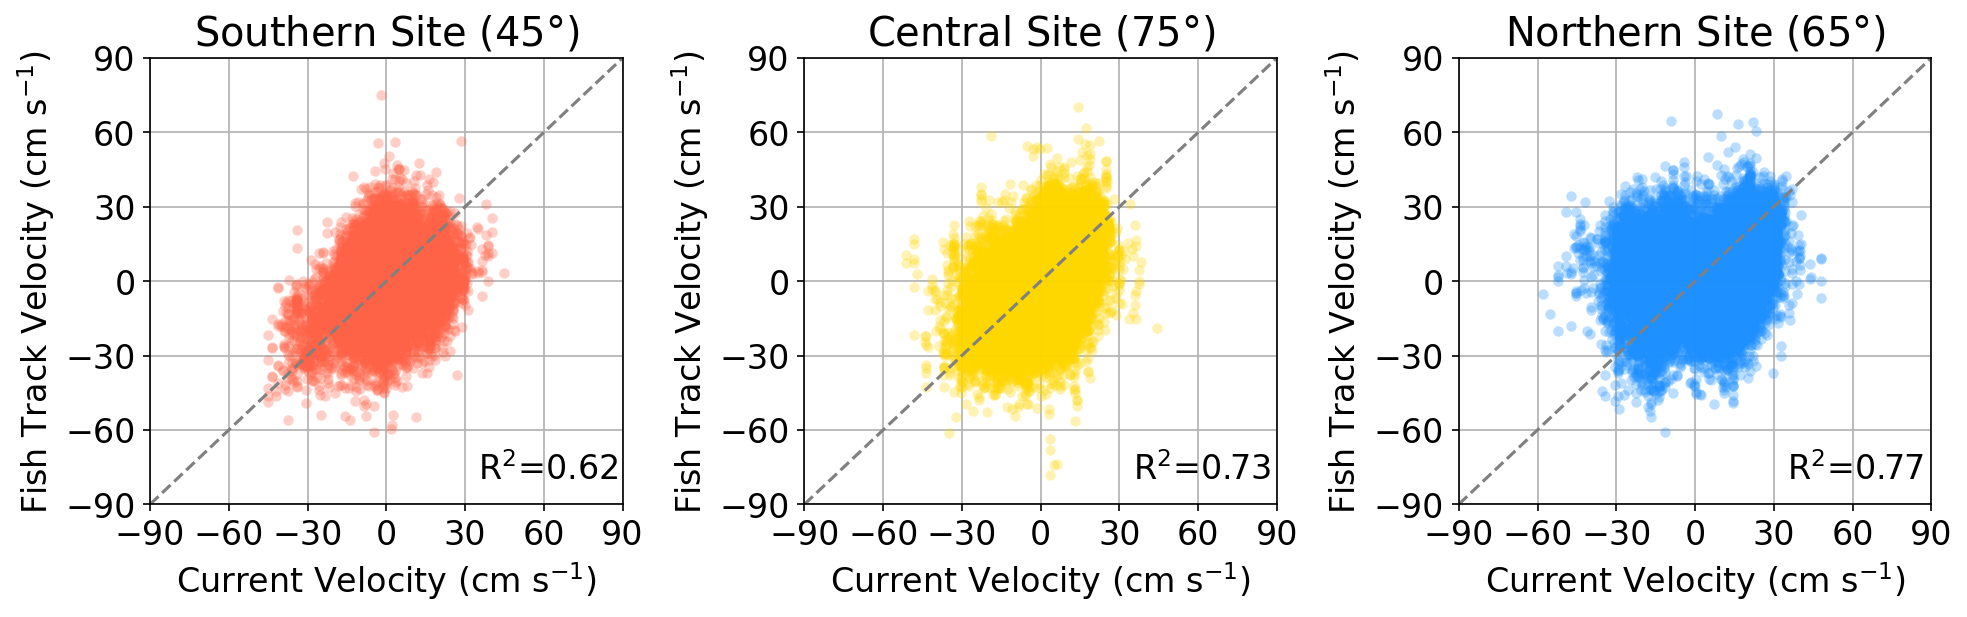

In [33]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)

df = dfMerge[dfMerge.mooring==1]
ax1.plot(df.adcpUrotated,df.trackUrotated,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax1.plot([-90,90],[-90,90],'--',color='grey')
ax1.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax1.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax1.set_xticks(np.arange(-90,91,30))
ax1.set_yticks(np.arange(-90,91,30))
ax1.axis([-90,90,-90,90])
ax1.set_title('Southern Site (45$\degree$)')
ax1.grid()
ax1.text(35,-80,'R$^{2}$='+str(np.round(np.corrcoef(df.adcpVrotated,df.trackVrotated)[0][1]**2,2)))

df = dfMerge[dfMerge.mooring==2]
ax2.plot(df.adcpUrotated,df.trackUrotated,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
ax2.plot([-90,90],[-90,90],'--',color='grey')
ax2.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax2.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax2.set_xticks(np.arange(-90,91,30))
ax2.set_yticks(np.arange(-90,91,30))
ax2.axis([-90,90,-90,90])
ax2.set_title('Central Site (75$\degree$)')
ax2.grid()
ax2.text(35,-80,'R$^{2}$='+str(np.round(np.corrcoef(df.adcpVrotated,df.trackVrotated)[0][1]**2,2)))

df = dfMerge[dfMerge.mooring==3]
ax3.plot(df.adcpUrotated,df.trackUrotated,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
ax3.plot([-90,90],[-90,90],'--',color='grey')
ax3.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax3.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax3.set_xticks(np.arange(-90,91,30))
ax3.set_yticks(np.arange(-90,91,30))
ax3.axis([-90,90,-90,90])
ax3.set_title('Northern Site (65$\degree$)')
ax3.grid()
ax3.text(35,-80,'R$^{2}$='+str(np.round(np.corrcoef(df.adcpVrotated,df.trackVrotated)[0][1]**2,2)))

r2 =  0.8112630547410319
r2 =  0.6169812884612437


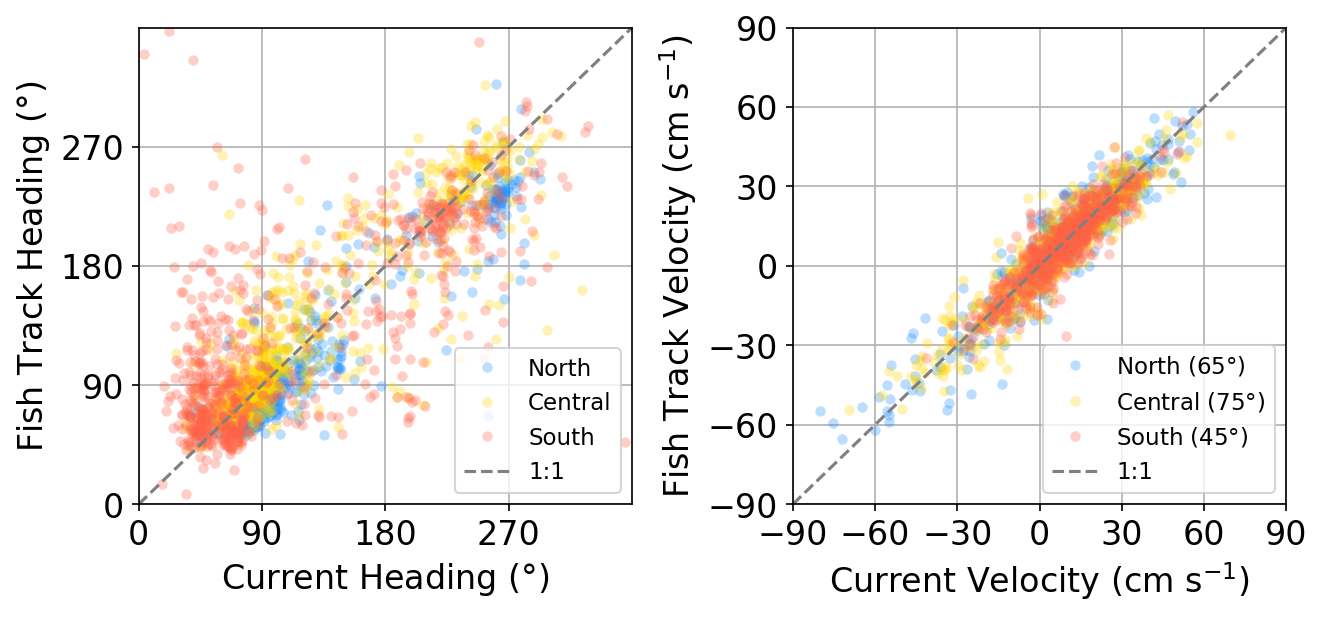

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.7,4),dpi=150)



df = dfMerge[dfMerge.mooring==3]
ax1.plot(df.resample('1D').mean().currentDir,df.resample('1D').mean().linearHead,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==2]
ax1.plot(df.resample('1D').mean().currentDir,df.resample('1D').mean().linearHead,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==1]
ax1.plot(df.resample('1D').mean().currentDir,df.resample('1D').mean().linearHead,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax1.plot([0,360],[0,360],'--',color='grey')
ax1.set_xlabel('Current Heading ($\degree$)')
ax1.set_ylabel('Fish Track Heading ($\degree$)')
#ax1.text(180,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir)[0][1]**2,2)))
ax1.axis([0,360,0,360])
ax1.set_xticks([0,90,180,270])
ax1.set_yticks([0,90,180,270])
ax1.legend(['North','Central','South','1:1'],fontsize=11, loc='lower right')
ax1.grid()


df = dfMerge[dfMerge.mooring==3]
ax2.plot(df.resample('1D').mean().adcpVrotated,df.resample('1D').mean().trackVrotated,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==2]
ax2.plot(df.resample('1D').mean().adcpVrotated,df.resample('1D').mean().trackVrotated,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==1]
ax2.plot(df.resample('1D').mean().adcpVrotated,df.resample('1D').mean().trackVrotated,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax2.plot([-90,90],[-90,90],'--',color='grey')
ax2.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax2.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax2.set_xticks(np.arange(-90,91,30))
ax2.set_yticks(np.arange(-90,91,30))
ax2.axis([-90,90,-90,90])
ax2.legend(['North (65$\degree$)','Central (75$\degree$)','South (45$\degree$)','1:1'],fontsize=11, loc='lower right')
ax2.grid()

print('r2 = ',np.corrcoef(df.resample('1D').mean().adcpVrotated[(~df.resample('1D').mean().adcpVrotated.isnull())&(~df.resample('1D').mean().trackVrotated.isnull())],
    df.resample('1D').mean().trackVrotated[(~df.resample('1D').mean().adcpVrotated.isnull())&(~df.resample('1D').mean().trackVrotated.isnull())])[0][1]**2)

print('r2 = ',np.corrcoef(df.adcpVrotated[(~df.adcpVrotated.isnull())&(~df.trackVrotated.isnull())],
    df.trackVrotated[(~df.adcpVrotated.isnull())&(~df.trackVrotated.isnull())])[0][1]**2)

In [144]:
dfMerge.trackVrotated.mean()

8.282443587819975

In [162]:
np.mean(dfMerge.trackVrotated-dfMerge.adcpVrotated)
#np.std(dfMerge.trackVrotated-dfMerge.adcpVrotated)

0.1940887221645973

r2 =  0.8112630547410319
r2 =  0.18532552142560224


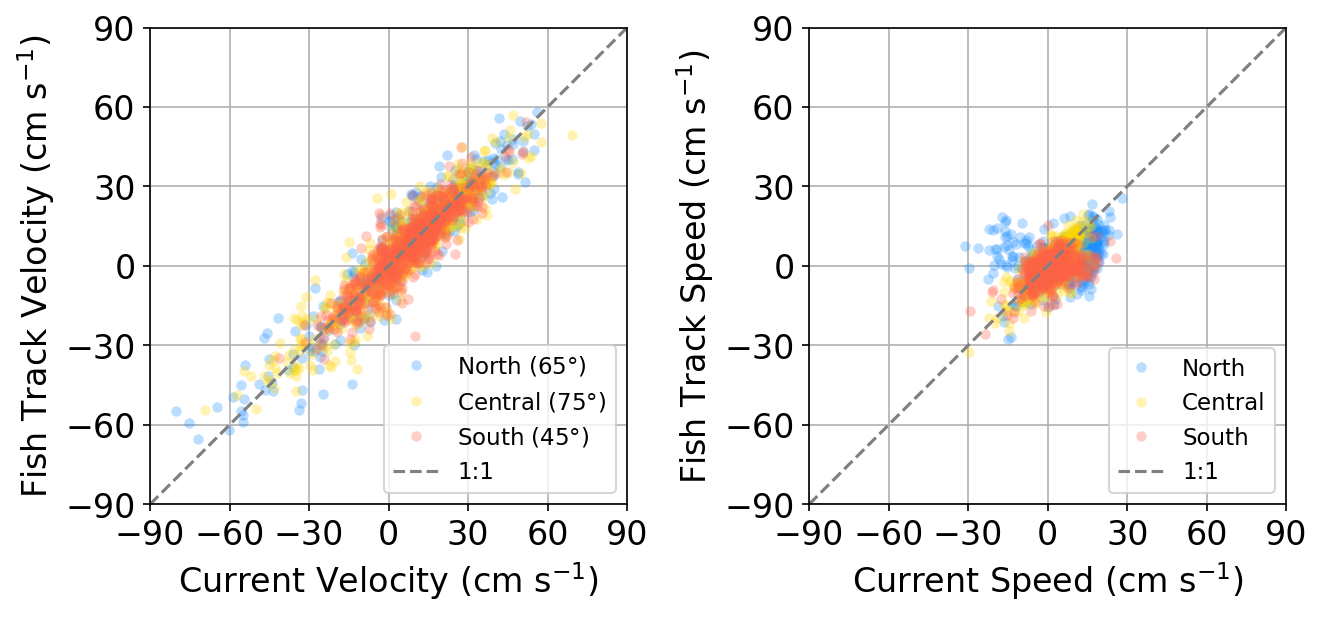

In [27]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.7,4),dpi=150)



df = dfMerge[dfMerge.mooring==3]
ax1.plot(df.resample('1D').mean().adcpVrotated,df.resample('1D').mean().trackVrotated,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==2]
ax1.plot(df.resample('1D').mean().adcpVrotated,df.resample('1D').mean().trackVrotated,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==1]
ax1.plot(df.resample('1D').mean().adcpVrotated,df.resample('1D').mean().trackVrotated,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax1.plot([-90,90],[-90,90],'--',color='grey')
ax1.set_ylabel('Fish Track Velocity (cm s$^{-1}$)')
ax1.set_xlabel('Current Velocity (cm s$^{-1}$)')
ax1.set_xticks(np.arange(-90,91,30))
ax1.set_yticks(np.arange(-90,91,30))
ax1.axis([-90,90,-90,90])
ax1.legend(['North (65$\degree$)','Central (75$\degree$)','South (45$\degree$)','1:1'],fontsize=11, loc='lower right')
ax1.grid()


df = dfMerge[dfMerge.mooring==3]
ax2.plot(df.resample('1D').mean().adcpUrotated,df.resample('1D').mean().trackUrotated,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==2]
ax2.plot(df.resample('1D').mean().adcpUrotated,df.resample('1D').mean().trackUrotated,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring==1]
ax2.plot(df.resample('1D').mean().adcpUrotated,df.resample('1D').mean().trackUrotated,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax2.plot([-90,90],[-90,90],'--',color='grey')
ax2.set_ylabel('Fish Track Speed (cm s$^{-1}$)')
ax2.set_xlabel('Current Speed (cm s$^{-1}$)')
ax2.set_xticks(np.arange(-90,91,30))
ax2.set_yticks(np.arange(-90,91,30))
ax2.axis([-90,90,-90,90])
ax2.legend(['North','Central','South','1:1'],fontsize=11, loc='lower right')
ax2.grid()

print('r2 = ',np.corrcoef(df.resample('1D').mean().adcpVrotated[(~df.resample('1D').mean().adcpVrotated.isnull())&(~df.resample('1D').mean().trackVrotated.isnull())],
    df.resample('1D').mean().trackVrotated[(~df.resample('1D').mean().adcpVrotated.isnull())&(~df.resample('1D').mean().trackVrotated.isnull())])[0][1]**2)

print('r2 = ',np.corrcoef(df.resample('1D').mean().adcpUrotated[(~df.resample('1D').mean().adcpUrotated.isnull())&(~df.resample('1D').mean().trackUrotated.isnull())],
    df.resample('1D').mean().trackUrotated[(~df.resample('1D').mean().adcpUrotated.isnull())&(~df.resample('1D').mean().trackUrotated.isnull())])[0][1]**2)

In [28]:
from scipy.stats import pearsonr
pearsonr(df.resample('1D').mean().adcpUrotated[(~df.resample('1D').mean().adcpUrotated.isnull())&(~df.resample('1D').mean().trackUrotated.isnull())],
    df.resample('1D').mean().trackUrotated[(~df.resample('1D').mean().adcpUrotated.isnull())&(~df.resample('1D').mean().trackUrotated.isnull())])

(0.4304945080086416, 7.848651399713317e-35)

In [8]:
print(len(dfMerge[dfMerge.mooring==1]))
print(len(dfMerge[dfMerge.mooring==2]))
print(len(dfMerge[dfMerge.mooring==3]))

63668
81458
40256


In [22]:
print(dfMerge.linearSpeed.mean())
print(dfMerge.linearSpeed.std())

0.23433825290481436
0.13535608469378252


In [654]:
print(dfMerge.currentSpeed.mean())
print(dfMerge.currentSpeed.std())

21.496484756469727
14.017512321472168


In [10]:
print(dfMerge.trackVrotated.mean())
print(dfMerge.trackVrotated.std())

8.282443587819975
23.308199758720463


In [29]:
print(dfMerge.trackUrotated.mean())
print(dfMerge.trackUrotated.std())

0.7366865868304697
10.95197207572006


In [122]:
# 300 km from bering strait to barrow canyon
dist = 600*1000 # to meters
t = dist/(.082)/60/60/24 # t in seconds
t

84.68834688346882

In [129]:
1.5E11/4.4E9

34.09090909090909

5.529293060302734
5.539155960083008
5.581207275390625


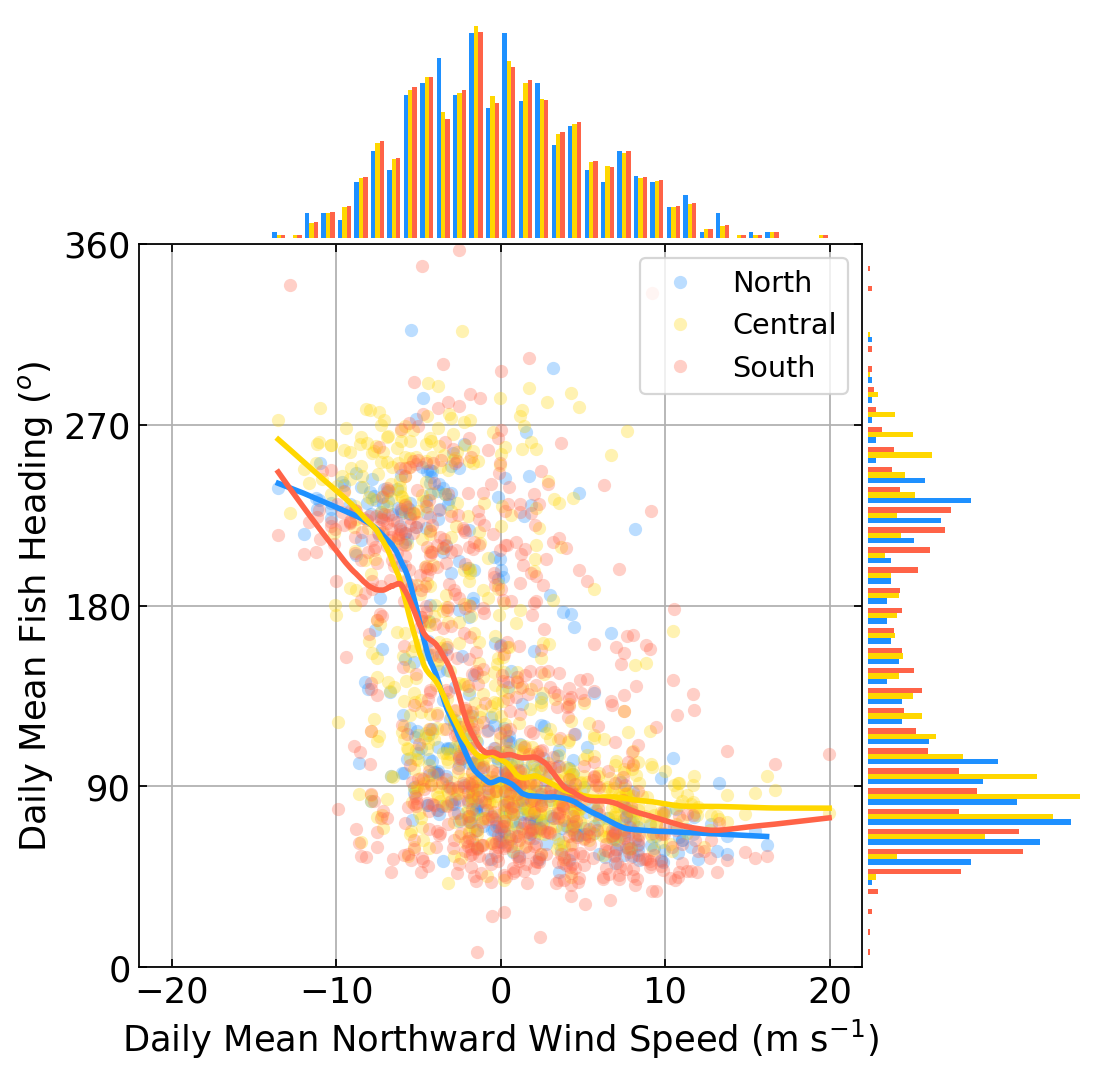

In [164]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.patheffects as pe


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(7, 7),dpi=159)
plt.rcParams.update({'font.size':16})
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

col=['dodgerblue','gold','tomato']
ct = 0
x,y = [],[]
for m in [3,2,1]:
    df = dfMerge[dfMerge.mooring == m]
    b = mp.wind_speed(dfWind.uwnd.values*units('m/s'),dfWind.vwnd.values*units('m/s'))
    dfWind['dir'] = b.magnitude
    a = pd.merge_asof(left=df.resample('1D').mean(),right=dfWind.resample('1D').mean(),right_index=True,left_index=True,direction='nearest')
    a = a[~a.linearHead.isnull()]
    ax_scatter.plot(a.vwnd,a.linearHead,'.',color = col[ct],alpha=0.3,markersize=12,markeredgecolor='None')
    print(np.std(a.vwnd))
    #linFit = olsFit(a.vwnd,a.linearHead)
    #print(linFit)
    #ax_scatter.plot([min(a.vwnd),max(a.vwnd)],[(linFit[1]*min(a.vwnd))+linFit[0],(linFit[1]*max(a.vwnd))+linFit[0]],linestyle='--',color=col[ct],label='_nolegend_')
    filtered = lowess( a.linearHead,a.vwnd, frac=.2)
    #ax_scatter.plot(filtered[:,0], filtered[:,1],linestyle='--',color=col[ct], lw=1.5, path_effects=[pe.Stroke(linewidth=2.5, foreground='k'), pe.Normal()],label='_nolegend_',zorder=10)
    ax_scatter.plot(filtered[:,0], filtered[:,1],linestyle='-',color=col[ct], lw=2.5,label='_nolegend_',zorder=10)
    ct+=1
    x.append(a.vwnd.values)
    y.append(a.linearHead.values)
    

ax_scatter.legend(['North','Central','South'],fontsize=13)
ax_scatter.set_yticks([0,90,180,270,360])
ax_scatter.grid()
# now determine nice limits by hand:
binwidth = 0.25
#lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-22,22))
ax_scatter.set_ylim((0,360))
ax_scatter.set_xlabel('Daily Mean Northward Wind Speed (m s$^{-1}$)')
ax_scatter.set_ylabel('Daily Mean Fish Heading ($^{o}$)')

ax_histx.hist(x, bins=np.arange(-15,25,1),density=True,color=col)
ax_histy.hist(y, bins=np.arange(0,360,10), orientation='horizontal',density=True,color=col)

ax_histx.set_xlim(ax_scatter.get_xlim())
#ax_histx.set_yticks([0,0.05])
ax_histx.set_axis_off()
ax_histy.set_ylim(ax_scatter.get_ylim())
#ax_histy.set_yticks([0,90,180,270,360])
ax_histy.set_axis_off()

plt.show()

In [12]:
from glob import glob
import xarray as xr
uf = glob('../data/physicalData/wind/uwnd*')
vf = glob('../data/physicalData/wind/vwnd*')
dsU = xr.open_mfdataset(uf)
dsV = xr.open_mfdataset(vf)
dsWind = dsU.merge(dsV)
dsWind.sel(lat=70,lon=195)
dfWind =dsWind.sel(lat=70,lon=195).to_dataframe()

Text(0.5, 0, 'Date')

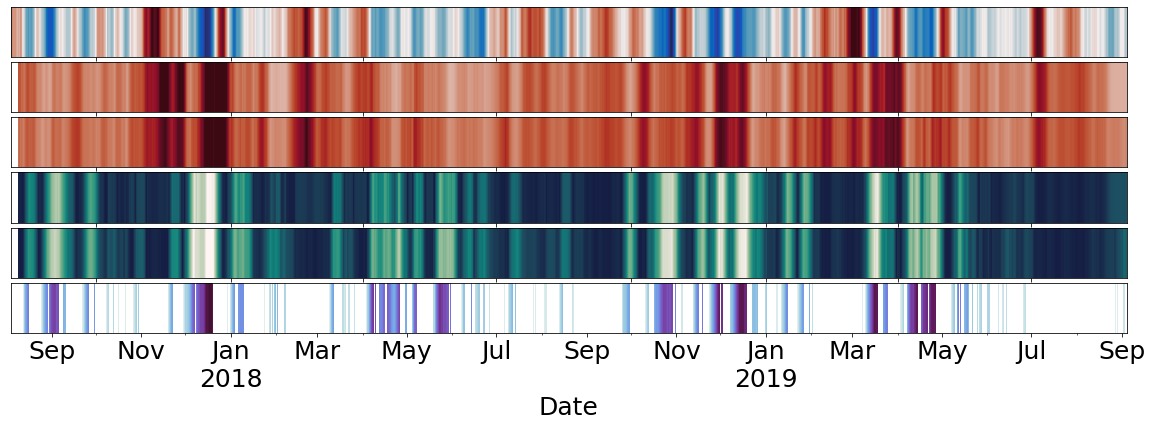

In [15]:
import matplotlib.pyplot as plt
import cmocean

mooring = 2
resample = '7D'
mooringoffset = [50,85,80]
if mooring == 3:
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,6))
else:    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(20,6))

dfCur = dfWind
dfCur['windSpeed'] = mp.wind_speed(dfCur.uwnd.values*units('m/s'), dfCur.vwnd.values*units('m/s'))
#wSpeed = dfCur.rolling(resample).mean().vwnd.values
wSpeed = dfCur.rolling(resample).mean().vwnd.values
t = dfCur.rolling(resample).mean().index.values

ax1.pcolormesh(t,[1,2],np.reshape(wSpeed,(1,len(wSpeed))),cmap=cmocean.cm.balance,vmin=-10, vmax=10)

dfCur = dfMerge[dfMerge.mooring==mooring]
dfCur = dfCur.resample('2H').mean()
t = dfCur.rolling(resample).mean().index.values
head = abs(dfCur.rolling(resample).mean().rotateHead.values)
cSpeed = dfCur.rolling(resample).mean().currentSpeed.values
tSpeed = dfCur.rolling(resample).mean().linearSpeed.values*100
cDir = dfCur.rolling(resample).mean().currentDir.values-mooringoffset[mooring-1]
cDir[cDir>180] = cDir[cDir>180]-360
cDir = abs(cDir)

d1 = dfCur[dfCur.withPrimary==2].rolling(resample).count()
d2 = dfCur.rolling(resample).count()
withCur = d1.withPrimary/d2.withPrimary
#withCur = withCur.fillna(0)


ax2.pcolormesh(t,[1,2],np.reshape(cSpeed,(1,len(cSpeed))),cmap=cmocean.cm.amp,vmin=0, vmax=40)
ax3.pcolormesh(t,[1,2],np.reshape(tSpeed,(1,len(tSpeed))),cmap=cmocean.cm.amp,vmin=0, vmax=40)
ax4.pcolormesh(t,[1,2],np.reshape(cDir,(1,len(cDir))),cmap=cmocean.cm.tempo_r,vmin=0, vmax=180)
ax5.pcolormesh(t,[1,2],np.reshape(head,(1,len(head))),cmap=cmocean.cm.tempo_r,vmin=0, vmax=180)
ax6.pcolormesh(withCur.index,[1,2],np.reshape(withCur.values,(1,len(withCur.rolling(resample).mean().values))),cmap=cmocean.cm.dense,vmin=0, vmax=1)
#ax1.text(pd.to_datetime('2017-08-15'),2.1,'Northward Wind Speed')
#ax2.text(pd.to_datetime('2017-08-15'),2.1,'ADCP Speed')
#ax3.text(pd.to_datetime('2017-08-15'),2.1,'Track Speed')
#ax4.text(pd.to_datetime('2017-08-15'),2.1,'ADCP Direction')
#ax5.text(pd.to_datetime('2017-08-15'),2.1,'Track Direction')
#ax6.text(pd.to_datetime('2017-08-15'),2.1,'% tracks S/E')
[a.set_xticklabels(['']) for a in [ax1,ax2,ax3,ax4,ax5]]
[a.set_yticklabels(['']) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
[a.set_yticks([]) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
if mooring == 3:
    [a.set_xlim([t[0],pd.to_datetime('2019-9-4')]) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
else:
    [a.set_xlim([pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4')]) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
plt.subplots_adjust(hspace=0.1)

plt.rcParams.update({'font.size':25})
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
ax6.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax6.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax6.xaxis.set_major_formatter(maj_fmt)
ax6.set_xlabel('Date')

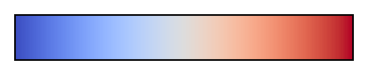

In [176]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

fig = plt.figure(figsize=(2.5, 2),dpi=150)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
#cmap = cmocean.cm.tempo
#cmap = cmocean.cm.amp
#cmap = cmocean.cm.dense
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=3)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_ticks([])

Text(-35, 40, 'R$^{2}$ = 0.72')

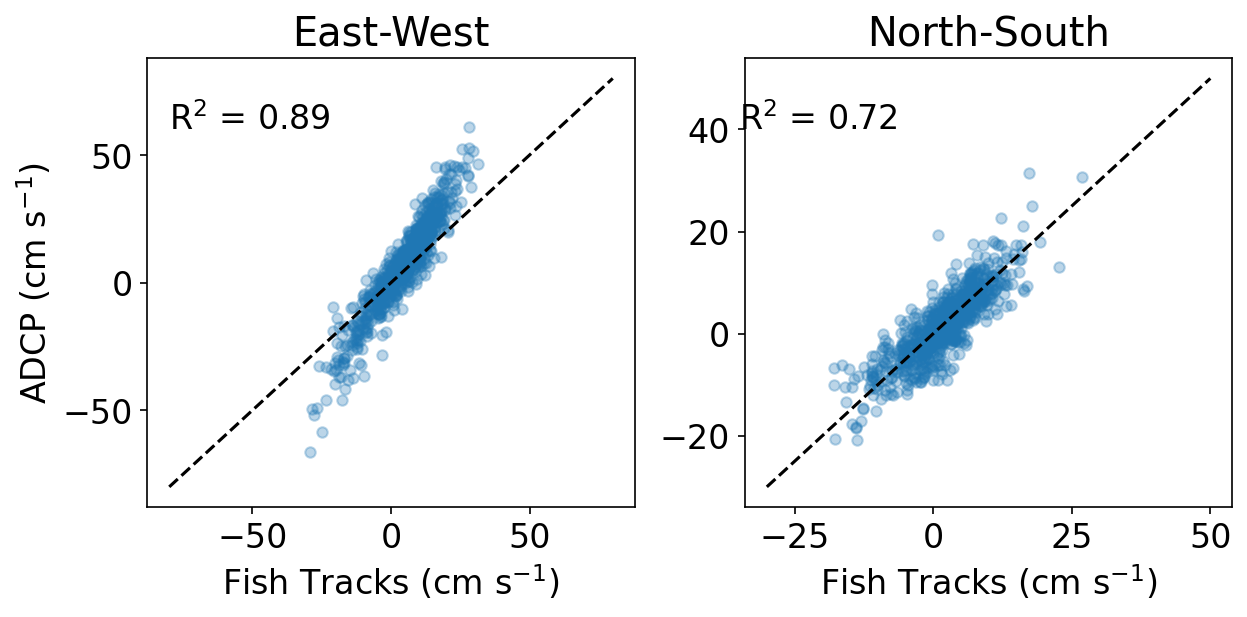

In [177]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.2,4),dpi=150)
ax1.plot(dfMerge.resample('1D').mean().u_track,dfMerge.resample('1D').mean().u,'.',markersize=10,alpha=.3)
ax1.plot([-80,80],[-80,80],'--k')
ax1.set_title('East-West')
ax1.set_ylabel('ADCP (cm s$^{-1}$)')
ax1.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax1.text(-80,60, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().u_track,dfMerge.resample('1D').mean().u)[0][1]**2,2)))

ax2.plot(dfMerge.resample('1D').mean().v_track,dfMerge.resample('1D').mean().v,'.',markersize=10,alpha=.3)
ax2.plot([-30,50],[-30,50],'--k')
ax2.set_title('North-South')
ax2.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax2.text(-35,40, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().v_track,dfMerge.resample('1D').mean().v)[0][1]**2,2)))

array([-58.8248375, -54.85032  , -51.3032015])

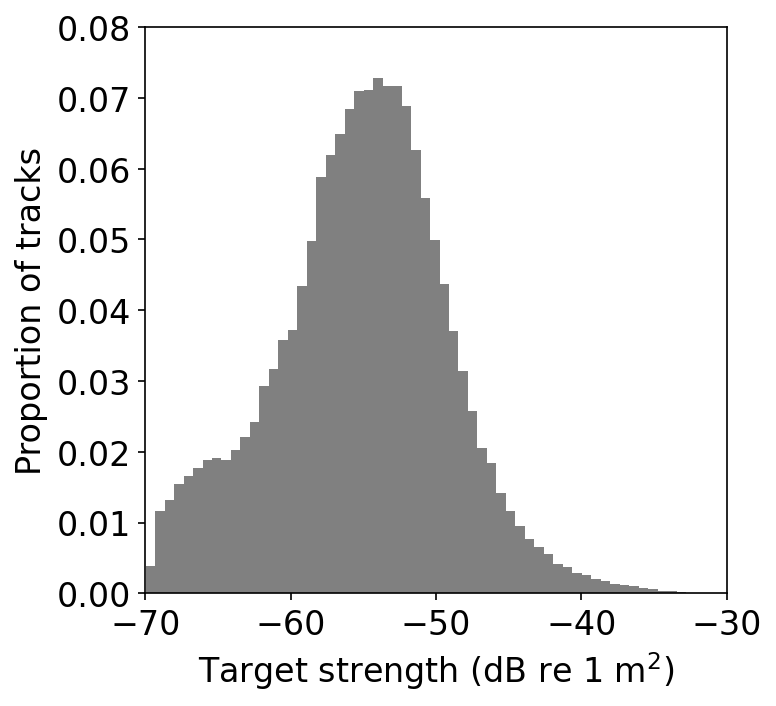

In [377]:
fig = plt.figure(figsize=(5,5),dpi=150)
plt.hist(dfMerge.TS_mean,bins=60,density=True,color='grey');
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')
plt.axis([-70,-30,0,.08])
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Target strength (dB re 1 m$^{2}$)')
plt.ylabel('Proportion of tracks')
dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values

In [400]:
10*np.log10(np.mean(10**(dfMerge[dfMerge.mooring_x==3].TS_mean/10)))

-49.78618941062607

In [402]:
dfMerge.TS_mean.mean()

-55.17487223821668

Text(0.5, 0, 'Target strength (dB re 1 m$^{2}$)')

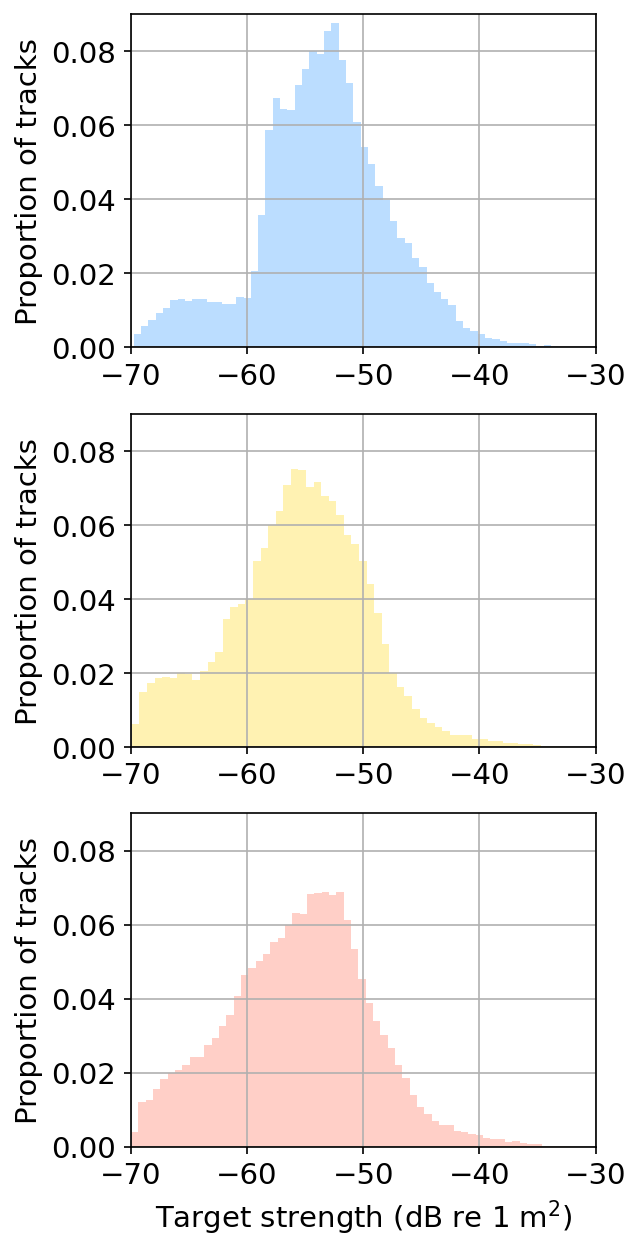

In [14]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':14})
fig = plt.figure(figsize=(4,10),dpi=150)
plt.subplot(311)
plt.hist(dfMerge[dfMerge.mooring==3].TS_mean,bins=60,density=True,color='dodgerblue',alpha=0.3);
plt.axis([-70,-30,0,.09])
plt.ylabel('Proportion of tracks')
plt.grid()
plt.subplot(312)
plt.hist(dfMerge[dfMerge.mooring==2].TS_mean,bins=60,density=True,color='gold',alpha=0.3);
plt.axis([-70,-30,0,.09])
plt.ylabel('Proportion of tracks')
plt.grid()
plt.subplot(313)
plt.hist(dfMerge[dfMerge.mooring==1].TS_mean,bins=60,density=True,color='tomato',alpha=0.3);
plt.axis([-70,-30,0,.09])
plt.ylabel('Proportion of tracks')
plt.grid()
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')

#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Target strength (dB re 1 m$^{2}$)')

In [21]:
len(allT[allT.Target_range_mean<=5])/len(allT)

0.06095767719166912

27.045788726408137
10.359650770047484


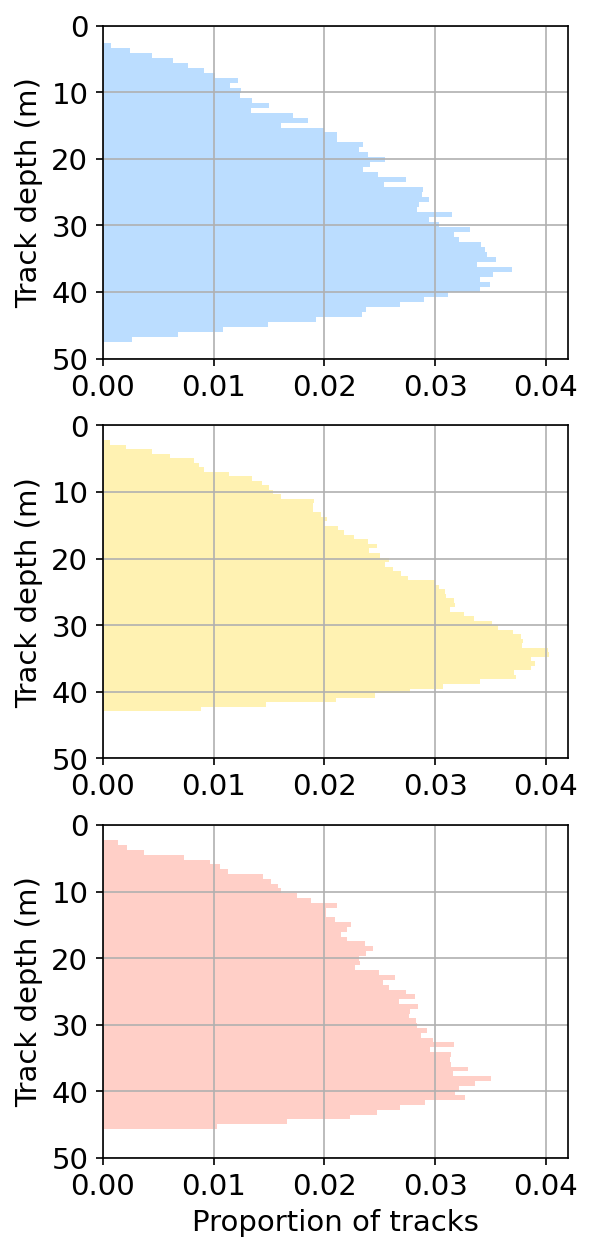

In [19]:
fig = plt.figure(figsize=(4,10),dpi=150)
plt.subplot(311)
plt.hist(dfMerge[dfMerge.mooring==3].Target_depth_mean,bins=60,density=True,color='dodgerblue',alpha=0.3,orientation='horizontal');
plt.ylabel('Track depth (m)')
plt.axis([0,0.042,0,50])
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(312)
plt.hist(dfMerge[dfMerge.mooring==2].Target_depth_mean,bins=60,density=True,color='gold',alpha=0.3,orientation='horizontal');
plt.ylabel('Track depth (m)')
plt.axis([0,0.042,0,50])
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(313)
plt.hist(dfMerge[dfMerge.mooring==1].Target_depth_mean,bins=60,density=True,color='tomato',alpha=0.3,orientation='horizontal');
plt.ylabel('Track depth (m)')
plt.axis([0,0.042,0,50])
plt.gca().invert_yaxis()
plt.grid()
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')
#plt.axis([-70,-30,0,.08])
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Proportion of tracks')

#plt.legend(['North','Central','South'],fontsize=13)
print(dfMerge.Target_depth_mean.mean())
print(dfMerge.Target_depth_mean.std())